In [1]:
import os
import random
import shutil

# Set up source and destination paths
source_folder = '/kaggle/input/vehicle-detection-8-classes-object-detection/train'
train_folder = '/kaggle/working/traindata'
test_folder = '/kaggle/working/testdata'
valid_folder = '/kaggle/working/validdata'

# Create destination folders
for folder in [train_folder, test_folder, valid_folder]:
    os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)

# Get list of image files
image_files = [filename for filename in os.listdir(os.path.join(source_folder, 'images')) if filename.endswith('.jpg')]

# Randomize the order of the image files
random.shuffle(image_files)

# Determine split sizes
train_size = int(0.7 * len(image_files))
test_size = int(0.15 * len(image_files))
valid_size = len(image_files) - train_size - test_size

# Copy images and labels to the destination folders
for i, filename in enumerate(image_files):
    image_path = os.path.join(source_folder, 'images', filename)
    label_path = os.path.join(source_folder, 'labels', filename.replace('.jpg', '.txt'))

    if i < train_size:
        destination_folder = train_folder
    elif i < train_size + test_size:
        destination_folder = test_folder
    else:
        destination_folder = valid_folder

    shutil.copy(image_path, os.path.join(destination_folder, 'images'))
    shutil.copy(label_path, os.path.join(destination_folder, 'labels'))


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 11.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2



In [4]:
num_classes = 8
classes = ['Motorcycle','Auto','Car','Bus','LCV(Light Motor Vehicle)','Truck','Tractor','Multi-Axle']


dict_file = {'train': os.path.join('/kaggle/working/', 'traindata'),
             'val': os.path.join('/kaggle/working/', 'validdata'),
             'test': os.path.join('/kaggle/working/', 'testdata'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join('/kaggle/working/', 'vehicledata.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['traindata', 'validdata', 'testdata']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join('/kaggle/working/', mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1


    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count


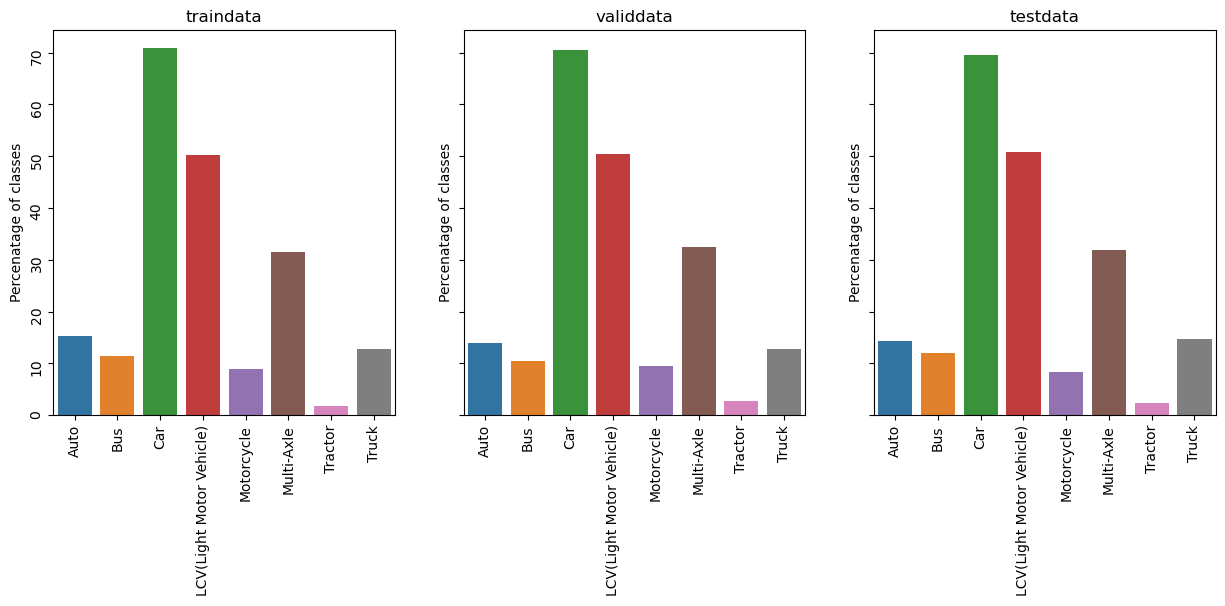

In [6]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['traindata', 'validdata','testdata']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()


In [7]:
import os
from PIL import Image

# Set up folder paths
train_folder = '/kaggle/working/traindata/images'
test_folder = '/kaggle/working/testdata/images'
valid_folder = '/kaggle/working/validdata/images'
target_size = (224, 224)  # Define the desired size for the images

# Function to resize images in a folder
def resize_images_in_folder(folder_path):
    # Get list of image files
    image_files = [filename for filename in os.listdir(folder_path) if filename.endswith('.jpg')]

    # Resize images in the folder
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Resize the image to the target size
        resized_image = image.resize(target_size)
        
        # Save the resized image
        resized_image.save(image_path)

# Resize images in the train folder
resize_images_in_folder(train_folder)

# Resize images in the test folder
resize_images_in_folder(test_folder)

# Resize images in the valid folder
resize_images_in_folder(valid_folder)


In [8]:
for mode in ['traindata', 'validdata', 'testdata']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join('/kaggle/working/', mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in traindata set:

	(224, 224)

Image sizes in validdata set:

	(224, 224)

Image sizes in testdata set:

	(224, 224)


In [9]:
for mode in ['traindata', 'validdata', 'testdata']:

    files =  glob.glob(os.path.join('/kaggle/working/', mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')


traindata set size: 5752

validdata set size: 1234

testdata set size: 1232



In [10]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 71.7MB/s]


In [11]:
model.train(data=os.path.join('/kaggle/working/','vehicledata.yaml'),
            task='detect',
            imgsz=224,
            epochs=10,
            batch=32,
            mode='train',
            name='yolov8n_v1_train')


Ultralytics YOLOv8.0.123 🚀 Python-3.10.10 torch-2.0.0+cpu CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/vehicledata.yaml, epochs=10, patience=50, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, 

UsageError: api_key not configured (no-tty). call wandb.login(key=[your_api_key])

In [ ]:
model = YOLO('runs/detect/yolov8n_v1_train4/weights/best.pt')


In [ ]:
results = model.predict(source=os.path.join('/kaggle/working/', 'testdata', 'images'), save=True)

In [ ]:
%matplotlib inline

predicitions = glob.glob(os.path.join('/kaggle/working/', 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()